In [999]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
plt.rcParams['image.origin'] = 'lower'

In [1000]:
# I started this from 
#   The Fraction of Broken Waves in Natural Surf Zones [Stringari & Power] https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JC015213
#   They reference:
#       Transformation of wave height distribution [Thornton & Guza] (1983) https://agupubs.onlinelibrary.wiley.com/doi/10.1029/JC088iC10p05925
#       Energy Loss and Set-Up Due to Breaking of Random Waves [Battjes & Janssen] (1978) https://ascelibrary.org/doi/10.1061/9780872621909.034

(-10.0, 1.0)

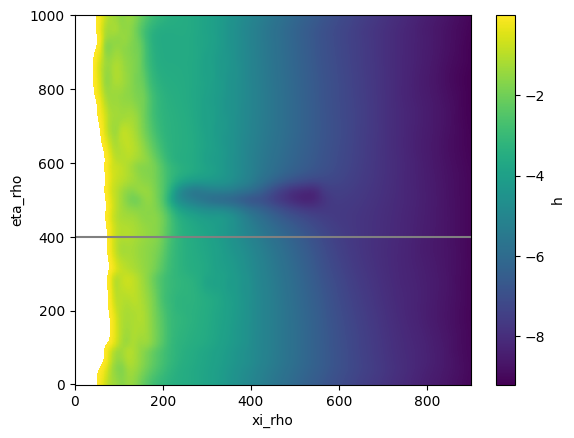

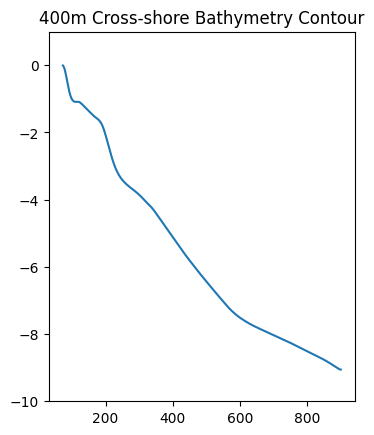

In [1048]:
# Take a bathy profile, in this case mission 32. We'll consider a cross shore transect at 400m alongshore in this reference frame
# TODO(@mleclair): Figure out what this is in FRF coordinates?
crossshore_loc = 400
bathy = xr.load_dataset('model/code/bathy/ocean_dunex_grd32.nc')
bathy['h'].values -= 0.8 # Hack to get the shoreline back. Something's wrong with this bathy file. #TODO(@mleclair) I should probably do this from the FRF Survey instead
bathy['h'].values *= -1 # Hack to get the shoreline back. Something's wrong with this bathy file. #TODO(@mleclair) I should probably do this from the FRF Survey instead
bathy['h'].values[bathy.h.values >= 0] = np.nan
bathy.h.plot()
plt.axhline(crossshore_loc, c='gray')
ny, nx = bathy.h.shape

# Here's that contour 
plt.figure()
h_contour = (-bathy.h.sel(eta_rho=crossshore_loc)).values
plt.plot(np.arange(901), -h_contour)
plt.title(f'{crossshore_loc}m Cross-shore Bathymetry Contour')
plt.gca().set_aspect(100)
plt.ylim(-10, 1)

In [1049]:
# Some metadata from this mission showing forcing from the 8m array
missions = pd.read_csv('data/mission_df.csv')
mission = missions[missions['mission number']==32]
mission

,Unnamed: 0,time,mission number,Hs [m],Tm [s],Mean Dir [deg],cross shore gamma location [m],break depth,freq [hz],energy density [m^2\hz],direction bins [deg],directional energy density [m^2/hz/deg],wind speed [m/s],wind direction [deg],water level [m]
39,39,2021-10-13 17:25:29.998680,32,1.091753,6.456496,59.175695,263.470935,3.119293,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.01459356204863603, 0.013802312733134417, 0....","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[4.0894119592849165e-05, 4.2284758819732815e-...",6.483833,4.238652,0.781


In [1050]:
# Let's calculate some wave statistics
H_s = mission['Hs [m]'].item()
H_rms = H_s / 2 * np.sqrt(2)

# Rough estimate of the total number of waves during the measurement period as # of peak periods
minutes_of_data = 120
N = (minutes_of_data * 60) / mission['Tm [s]'].item() 

# Maximum wave height following 
# The statistical distribution of the maxima of a random function  [Cartwright & Longuet-Higgins, 1956] https://doi.org/10.1098/rspa.1956.0173
H_max = (np.log(N)**0.5 + 0.2886 * np.log(N)**-0.5)*H_rms
print(f"{H_s=:.2f}m")
print(f"{H_rms=:.2f}m")
print(f"{H_max=:.2f}m")

H_s_offshore = H_s
H_rms_offshore = H_rms
H_max_offshore = H_max

H_s=1.09m
H_rms=0.77m
H_max=2.13m


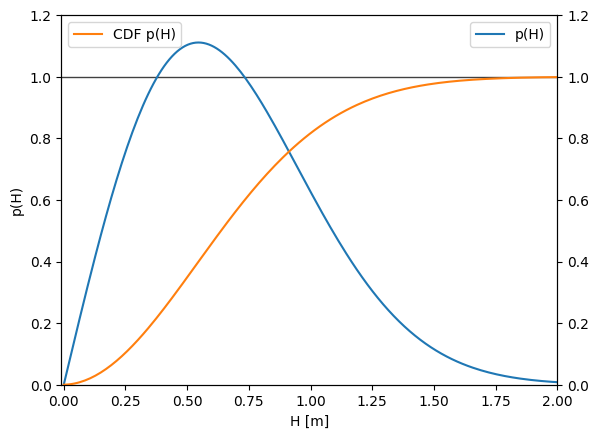

In [1051]:
# Create a wave height distribution (Rayleigh PDF). 
# This distribution describes the off-shore conditions
nH = 200
H = np.linspace(0, H_max, nH)
dH = H[1] - H[0]
# Default to the off-shore p(H), H_rms will change as the waves break and shoal
def p(H, H_rms=H_rms_offshore):
    return 2*H / H_rms**2 * np.exp(-(H/H_rms)**2)

# Plot PDF & CDF 
fig, ax = plt.subplots()
ax.plot(H, p(H), label='p(H)')
ax.set_ylim(0, 1.2)
ax.set_xlim(-0.01, 2)
ax.set_ylabel('p(H)')
ax.set_xlabel('H [m]')
ax.axhline(1, c='k', alpha=0.75, linewidth=1, zorder=-1)
ax.legend()
ax1 = plt.twinx()
ax1.plot(H, np.cumsum(p(H)*dH), c='tab:orange', label='CDF p(H)')
ax1.set_ylim(0, 1.2)
ax1.legend(loc=2)

# This next portion follows TG'89
$p_b(H) = W(H)p(H)$

$p(H) = \frac{2H}{H_{rms}^2}exp[-(\frac{H}{H_{rms}})^2]$

The simplest hypothesis, that break proportional to the height distribution is 

$W(H) = A_b = (\frac{H_{rms}}{\gamma h})^n$

The following modification more heavily weights large waves

$W(H) = (\frac{H_{rms}}{\gamma h})^n[1-exp(-(\frac{H}{\gamma h})^2)] \leq 1$

$Q_b = \int_0^{\infty} p_b(H) dH$

## $W(H)$
T&G use these weighting functions to describe the probability of each wave height breaking $p_b(H)$

Text(0.5, 1.0, '$W(H) = (\\frac{H_{rms}}{\\gamma h})^n \\cdot [1 - exp((\\frac{H}{\\gamma h})^2)] \\leq 1$')

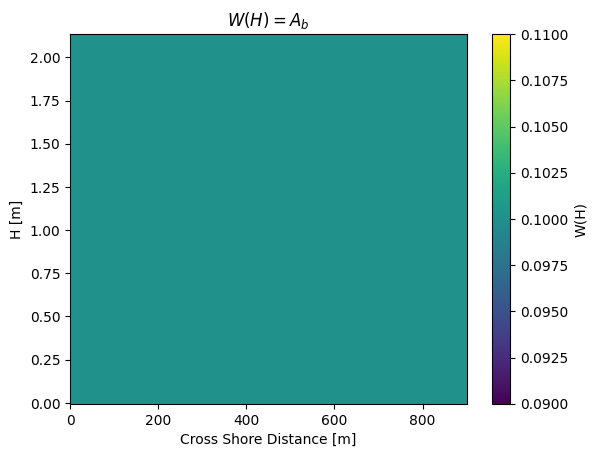

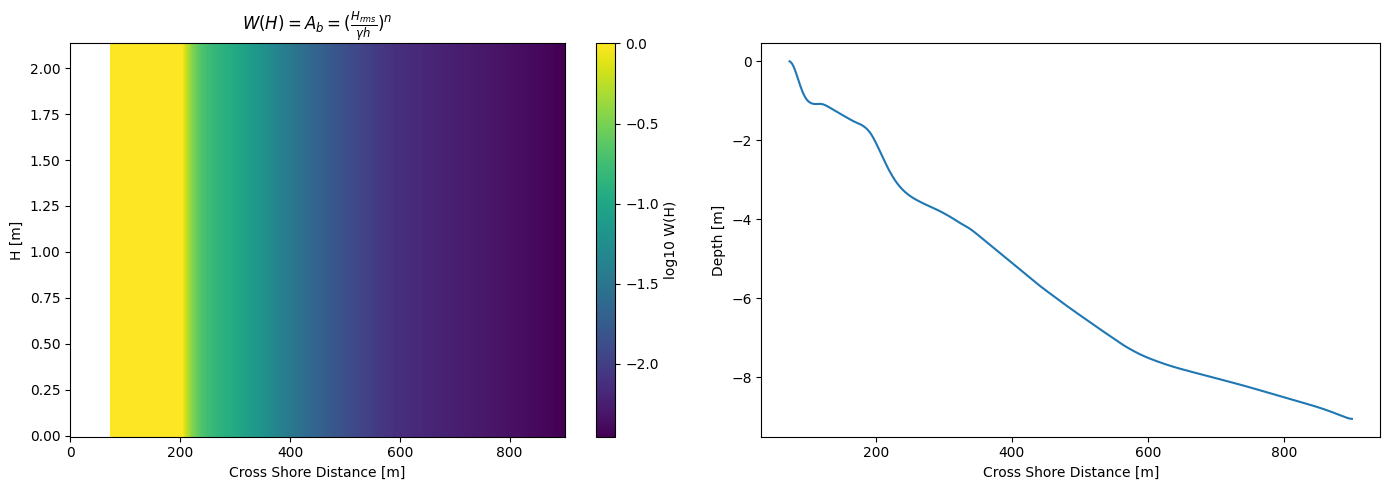

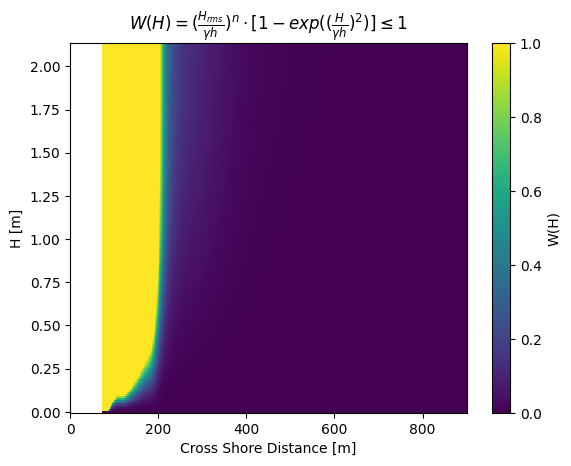

In [1005]:
# We've already described p(H) above, now we need to describe the weighting functions used in TG89 to describe the probability of breaking

# To visualize this we'll create a grid of (H, X), (Wave heights, Cross-shore grid points)
H_grid = (np.ones(nx)[:, np.newaxis] * H[np.newaxis, :]).T
assert(H_grid.shape == (nH, nx))

# Simple weighting proportional to p(H)
A_b = 0.1
w_constant = lambda H: np.ones_like(H) * A_b
plt.figure()
plt.pcolormesh(
    np.arange(nx), H,
    w_constant(H_grid)
)
plt.xlabel('Cross Shore Distance [m]')
plt.ylabel('H [m]')
plt.colorbar(label='W(H)')
plt.title('$W(H) = A_b$')


# Simple weighting proportional to p(H) and h

# Free parameters
n = 4 # This N can be fit from observations. TG89 finds 4 works better than 2
gamma = 0.35 # This is also fit to observations, values range from ~0.3-0.8. TG89 uses 0.42 as the cannonical value

def w_prop_depth(H, h=h_contour, gamma=0.35, n=4):
    return np.minimum(np.ones_like(H) * (H_rms/gamma/h)**n, 1)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
im = axs[0].pcolormesh(
    np.arange(nx), H,
    np.log10(w_prop_depth(H_grid))
)
axs[0].set_xlabel('Cross Shore Distance [m]')
axs[0].set_ylabel('H [m]')
plt.colorbar(im, ax=axs[0], label='log10 W(H)')
axs[0].set_title(r'$W(H) = A_b = (\frac{H_{rms}}{\gamma h})^n$')
axs[1].plot(np.arange(nx), -h_contour)
axs[1].set_xlabel('Cross Shore Distance [m]')
axs[1].set_ylabel('Depth [m]')
plt.tight_layout()

# Bias the weighting towards larger waves. 
"""Observations show that at a particular location the largest waves are more likely to break.
Hence a greater proportion of the larger waves contribute to the breaking wave distribution,
resulting in the breaking wave distribution generally being skewed to the higher waves relative to the Rayleigh"""
# See figure 10 from TG89

def w(H, H_rms=H_rms_offshore, h=h_contour, gamma=0.35, n=4):
    return np.minimum((H_rms/gamma/h)**n * (1 - np.exp(-(H/gamma/h)**2)), 1)

plt.figure()
plt.pcolormesh(
    np.arange(nx), H,
    w(H_grid)
)
plt.xlabel('Cross Shore Distance [m]')
plt.ylabel('H [m]')
plt.colorbar(label='W(H)')
plt.title(r'$W(H) = (\frac{H_{rms}}{\gamma h})^n \cdot [1 - exp((\frac{H}{\gamma h})^2)] \leq 1$')

## $p_b(H)$
Now we have the PDF of wave heights p(H) and the breaking weighting W(H). Combine the two to get $p_B(H)$, the probability of breaking

$p_b(H) = W(H)p(H)$


(0.0, 1.0)

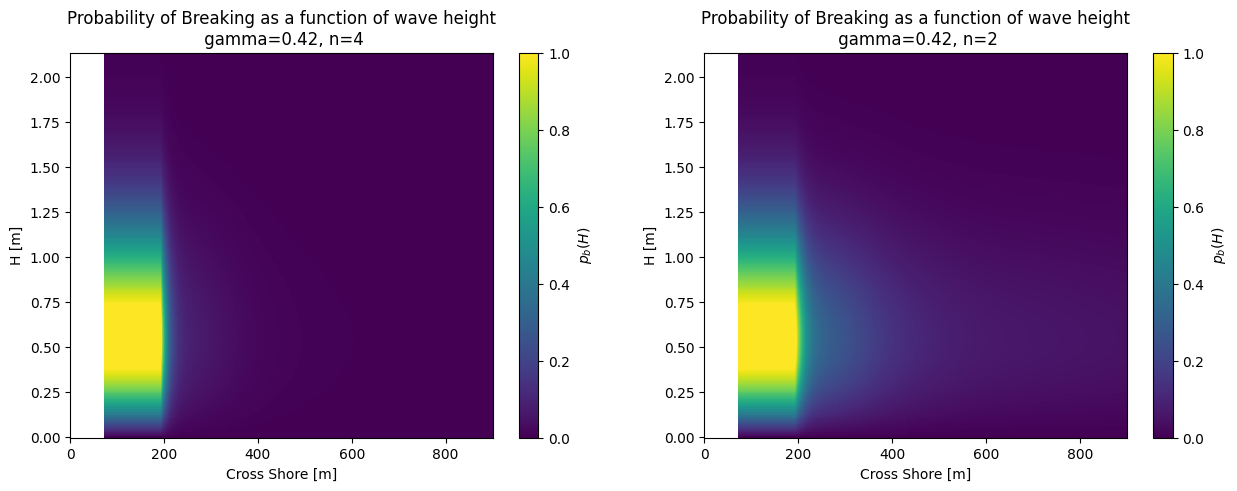

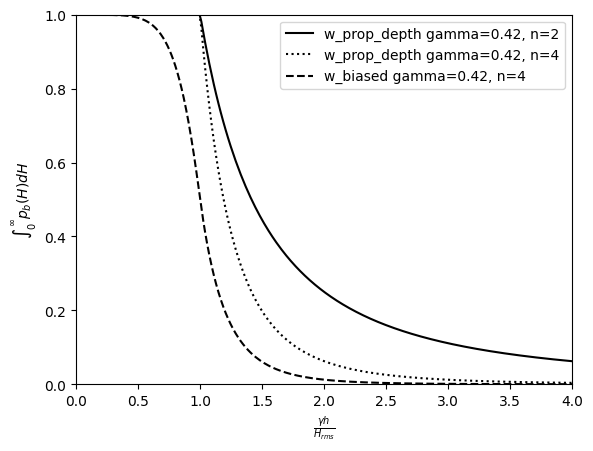

In [1006]:
gamma=0.42; n=4
pb =  p(H)[:, np.newaxis] * w_prop_depth(H_grid, h=h_contour, gamma=gamma, n=n)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
im = axs[0].pcolormesh(np.arange(nx), H, pb, vmin=0, vmax=1)
plt.colorbar(im, ax=axs[0], label='$p_b(H)$')
axs[0].set_title(f'Probability of Breaking as a function of wave height\n {gamma=}, {n=}')
axs[0].set_xlabel('Cross Shore [m]')
axs[0].set_ylabel('H [m]')

n=2
pb =  p(H)[:, np.newaxis] * w_prop_depth(H_grid, h=h_contour, gamma=gamma, n=n)
im = axs[1].pcolormesh(np.arange(nx), H, pb, vmin=0, vmax=1)
plt.colorbar(im, ax=axs[1], label='$p_b(H)$')
axs[1].set_title(f'Probability of Breaking as a function of wave height\n {gamma=}, {n=}')
axs[1].set_xlabel('Cross Shore [m]')
axs[1].set_ylabel('H [m]')

# This follows Figure 11 from TG89. 
# NOTE: Maybe their p(H) is substantially different? They should look more similar
plt.figure()
n=2
plt.plot(
    gamma * h_contour/H_rms,
    np.sum(
        p(H)[:, np.newaxis] * w_prop_depth(H_grid, h=h_contour, gamma=gamma, n=n), 
    axis=0) * dH,
    label=f'w_prop_depth {gamma=}, {n=}',
    c='k',
    linestyle='-'
)
n=4
plt.plot(
    gamma * h_contour/H_rms,
    np.sum(
        p(H)[:, np.newaxis] * w_prop_depth(H_grid, h=h_contour, gamma=gamma, n=n), 
    axis=0) * dH,
    label=f'w_prop_depth {gamma=}, {n=}',
    c='k',
    linestyle=':'
)
plt.plot(
    gamma * h_contour/H_rms,
    np.sum(
        p(H)[:, np.newaxis] * w(H_grid, h=h_contour, gamma=gamma, n=n), 
    axis=0) * dH,
    label=f'w_biased {gamma=}, {n=}',
    c='k',
    linestyle='--'
)
plt.xlabel(r'$\frac{\gamma h}{H_{rms}}$')
plt.ylabel(r'$\int_0^\infty p_b(H) dH$')
plt.legend()
plt.xlim(0, 4)
plt.ylim(0, 1)


# $Q_b$

Now we've calculated the probability of breaking along the cross-shore transect. We can easily calculate Q_b from this quantity.

$Q_b = \int_0^{\infty} p_b(H) dH$

Text(0, 0.5, 'Qb')

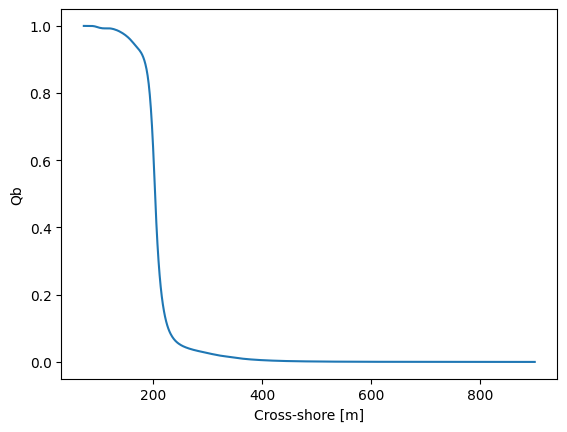

In [1007]:
# First for a single profile
plt.figure()
n=2
plt.plot(
    np.arange(nx),
    np.sum(
        p(H)[:, np.newaxis] * w(H_grid), 
    axis=0) * dH,
    label=f'qb {gamma=}, {n=} {crossshore_loc=}',
)
plt.xlabel('Cross-shore [m]')
plt.ylabel('Qb')



Text(0, 0.5, 'Mean Alongshore TG89 $Q_b$')

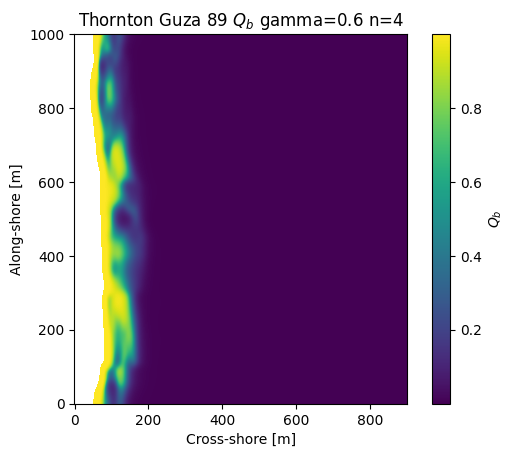

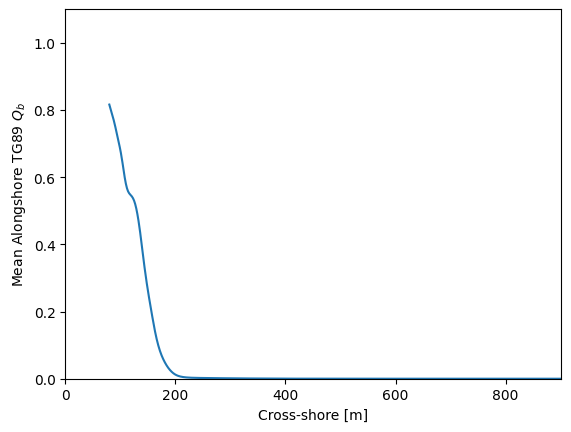

In [1008]:
gamma = 0.6; n=4

qb = np.zeros_like(bathy.h.values)
for i in range(1001):
    # Take the cross-shore bathy profile
    h = (bathy.h.isel(eta_rho=i)).values
    # Calculate probability of  breaking
    pb = p(H)[:, np.newaxis] * w(H_grid, h=h, gamma=gamma, n=n)
    qb[i, :] = np.sum(pb, axis=0) * dH

plt.imshow(qb)
plt.colorbar(label='$Q_b$')
plt.title(f'Thornton Guza 89 $Q_b$ {gamma=} {n=}')
plt.xlabel('Cross-shore [m]')
plt.ylabel('Along-shore [m]')

# Construct an average profile
plt.figure()
plt.plot(qb.mean(axis=0))
plt.xlim(0, 901)
plt.ylim(0, 1.1)
plt.xlabel('Cross-shore [m]')
plt.ylabel('Mean Alongshore TG89 $Q_b$')

# Construct a better average profile

Text(0, 0.5, 'Along-shore [m]')

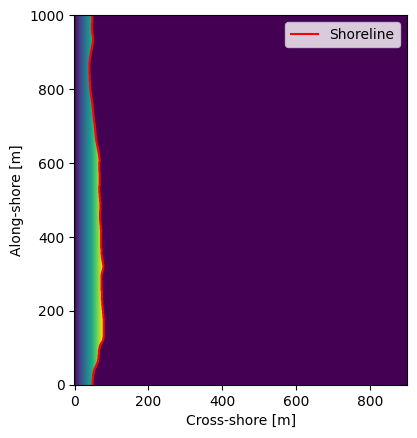

In [1009]:
# Pick out the shoreline
plt.imshow(np.isnan(bathy.h) * np.arange(0, 901))
shoreline = np.argmax(
    np.isnan(bathy.h.values) * np.arange(0, 901),
    axis=1)
plt.plot(shoreline, np.arange(1001), c='r', label='Shoreline')
plt.legend()
plt.xlabel('Cross-shore [m]')
plt.ylabel('Along-shore [m]')

Text(0.5, 1.0, 'Shore Aligned $Q_b$')

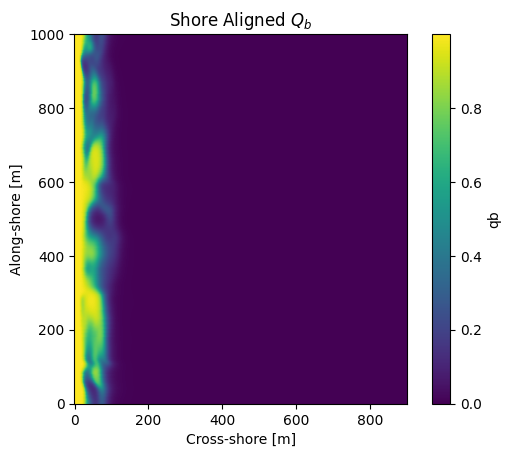

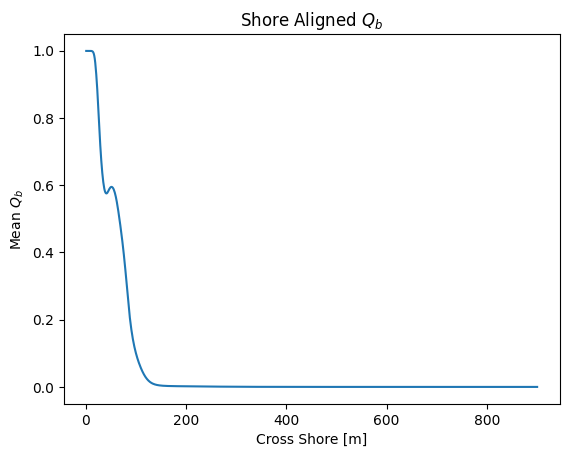

In [1010]:
# Calculate shore-aligned QB
aligned_qb = np.zeros_like(qb)
for i, start in enumerate(shoreline):
    aligned_qb[i, 0:aligned_qb.shape[1] - start] = qb[i, start:]
plt.imshow(aligned_qb)
plt.colorbar(label='qb')
plt.title('Shore Aligned $Q_b$')
plt.xlabel('Cross-shore [m]')
plt.ylabel('Along-shore [m]')

plt.figure()
plt.plot(aligned_qb.mean(0))
plt.xlabel('Cross Shore [m]')
plt.ylabel('Mean $Q_b$')
plt.title('Shore Aligned $Q_b$')

# Changing $p(H)$
The whole previous section only considered the off-shore p(H). In reality p(H) is going to change as the waves approach the shore. Two things will modify p(H), breaking (which will remove waves from the distribution), and shoaling (which will increase wave heights, shifting the distribution). For now I'm only considering breaking as the modification

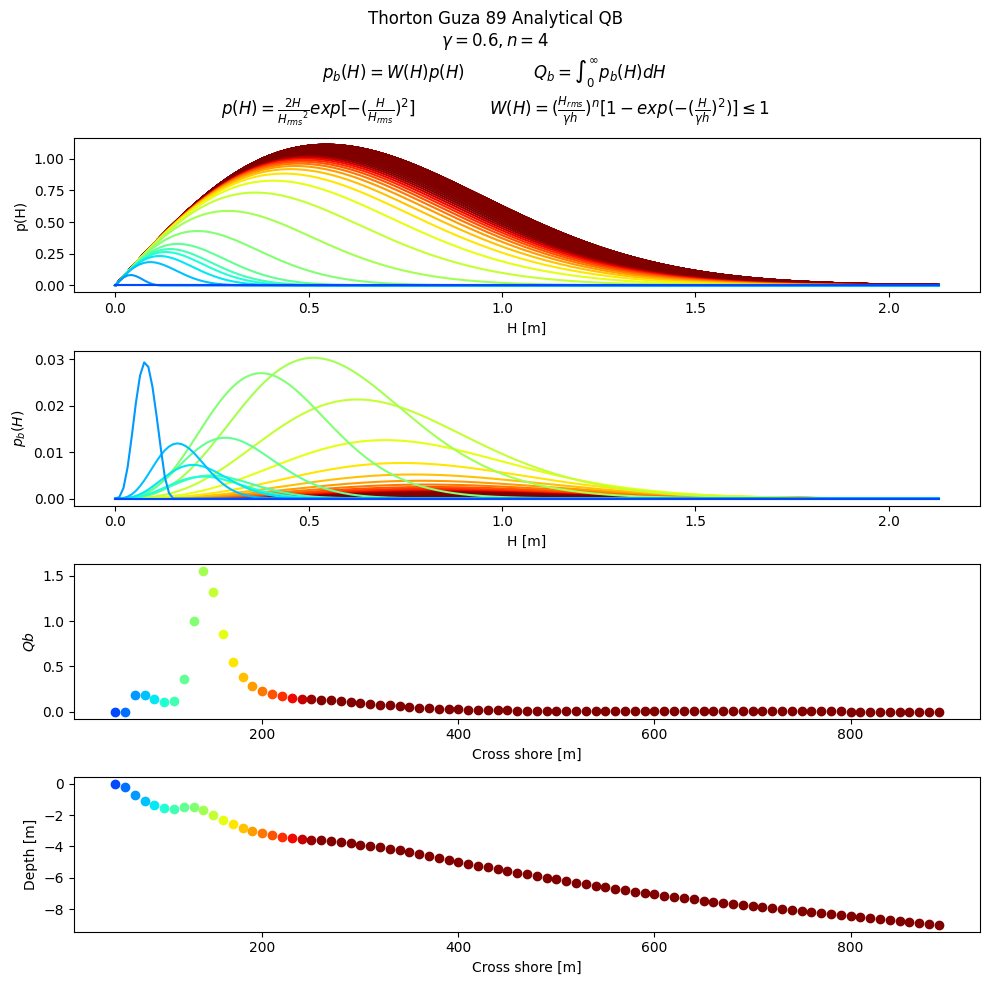

In [1011]:
# Note. This does not change H_rms in the weighting function which seems wrong?
gamma = 0.6
n=4
i = 0
pH = p(H)
colors = plt.cm.jet(np.arange(900))    
for j in reversed(range(900)):
    h = (bathy.h.isel(eta_rho=i)).values[j]


fig, axs = plt.subplots(4, 1, figsize=(10,10))
for j in reversed(range(900)):
    h = (bathy.h.isel(eta_rho=i)).values[j]
    pb = pH * w(H, h=h, gamma=gamma, n=n)
    pH -= pb
    # pH /= (np.sum(pH) * dH)
    c=plt.cm.jet(j)
    if j%10 == 0:
        axs[0].plot(H, pH, color=c)
        axs[1].plot(H, pb, color=c)
        axs[2].scatter(j, np.sum(pb), color=[c])
        axs[3].scatter(j, h, c=[c])


axs[0].set_xlabel('H [m]')
axs[0].set_ylabel('p(H)')

axs[1].set_xlabel('H [m]')
axs[1].set_ylabel('$p_b(H)$')

axs[2].set_xlabel('Cross shore [m]')
axs[2].set_ylabel('$Qb$')
axs[3].set_xlabel('Cross shore [m]')
axs[3].set_ylabel('Depth [m]')    

fig.suptitle(
('Thorton Guza 89 Analytical QB\n'
rf'$\gamma = {gamma}, n={n}$'
'\n'
r'$p_b(H) = W(H)p(H)$'
'\t\t'
r'$Q_b = \int_0^{\infty} p_b(H) dH$'
'\n'
r'$p(H) = \frac{2H}{{H_{rms}}^2}exp[-(\frac{H}{H_{rms}})^2]$'
'\t\t'
r'$W(H) = (\frac{H_{rms}}{\gamma h})^n[1-exp(-(\frac{H}{\gamma h})^2)] \leq 1$'))
plt.tight_layout()


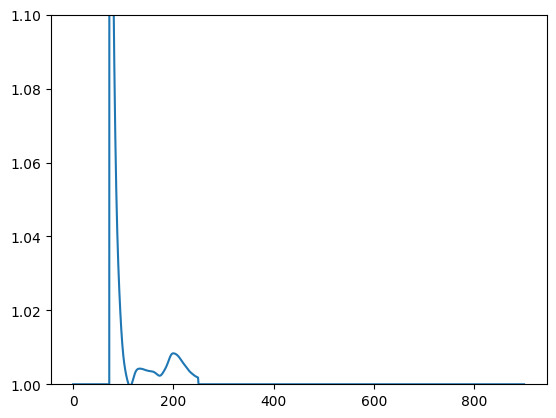

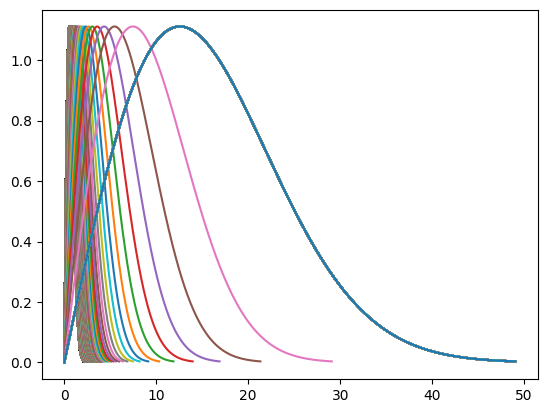

In [1012]:
shoaling_coefficient = np.nan_to_num(np.sqrt(bathy.h.values[400, 1:] / bathy.h.values[400, :-1]), nan=1)
shoaling_coefficient[250:] = 1
plt.plot(shoaling_coefficient)
plt.ylim(1, 1.1)
plt.figure()

plt.plot(H, p(H))
shoaled_h = H.copy()
for i in reversed(range(nx-1)):
    shoaled_h *= shoaling_coefficient[i]
    plt.plot(shoaled_h, p(H))
# plt.plot(H, p(H))

In [1111]:
# This version is more correct. It updates H_rms as the waves break and shoal optionally 
from joblib import Parallel, delayed
from tqdm import tqdm

gammas = np.linspace(0.2, 0.6, 5)

def compute_qb_stationary_H(gamma, bathy):
    pH = p(H)
    qb_local = np.zeros(901)
    for j in reversed(range(900)):
        pb = pH * w(H, h=bathy[j], gamma=gamma, n=2)
        # pH -= pb
        qb_local[j] = np.minimum(np.sum(pb), 1)
    return qb_local

# Computes Qb for a cross-shore transect, modifying p(H) as waves break
def compute_qb(gamma, bathy, update_H=True, update_Hrms=False, shoal_H=False):
    pH = p(H)
    hrms=np.nan_to_num(np.sqrt(np.trapz(H**2 * pH, H)), 0)
    qb_local = np.zeros(901)
    shoaled_H = H.copy() 
    for j in reversed(range(900)):
        if shoal_H:
            shoaled_H *= shoaling_coefficient[i]
        
        if update_Hrms:
            hrms=np.nan_to_num(np.sqrt(np.trapz(shoaled_H**2 * pH, shoaled_H)), 1e-9)
        
        pb = pH * w(shoaled_H, H_rms=hrms, h=bathy[j], gamma=gamma, n=4)
        if update_H:
            pH -= pb
        
        qb_local[j] = np.minimum(np.sum(pb)*dH, 1)
    return qb_local

# Parallelized loop
qb_static_H = np.zeros((len(gammas), 1001, 901))
qb_static_hrms = np.zeros((len(gammas), 1001, 901))
qb_changing_hrms = np.zeros((len(gammas), 1001, 901))
qb_changing_hrms_and_shoaling = np.zeros((len(gammas), 1001, 901))

for g in tqdm(range(len(gammas))):
    print(f'{gammas[g]=}')
    qb_static_H[g, :, :] = Parallel(n_jobs=-1)(delayed(compute_qb)(gammas[g], -bathy.h.isel(eta_rho=i).values, update_H=False) for i in range(1001))
    qb_static_hrms[g, :, :] = Parallel(n_jobs=-1)(delayed(compute_qb)(gammas[g], -bathy.h.isel(eta_rho=i).values) for i in range(1001))
    qb_changing_hrms[g, :, :] = Parallel(n_jobs=-1)(delayed(compute_qb)(gammas[g], -bathy.h.isel(eta_rho=i).values, update_Hrms=True) for i in range(1001))
    qb_changing_hrms_and_shoaling[g, :, :] = Parallel(n_jobs=-1)(delayed(compute_qb)(gammas[g], -bathy.h.isel(eta_rho=i).values, update_Hrms=True, shoal_H=True) for i in range(1001))

  0%|          | 0/5 [00:00<?, ?it/s]

gammas[g]=0.2


 20%|██        | 1/5 [00:06<00:26,  6.58s/it]

gammas[g]=0.3


 40%|████      | 2/5 [00:13<00:20,  6.72s/it]

gammas[g]=0.4


 60%|██████    | 3/5 [00:20<00:13,  6.71s/it]

gammas[g]=0.5


 80%|████████  | 4/5 [00:26<00:06,  6.55s/it]

gammas[g]=0.6


100%|██████████| 5/5 [00:32<00:00,  6.58s/it]


/var/folders/xv/4vxt441n3tz_yllzvqvzmsgw0000gr/T/ipykernel_95186/2160989942.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(qb[g]), vmin=np.log10(qb_min), vmax=np.log10(qb_max))


Text(0.5, 0.98, 'Thorton & Guza 89 $Q_b$, n=4\n H_rms updated with p(H), and shoaling on H')

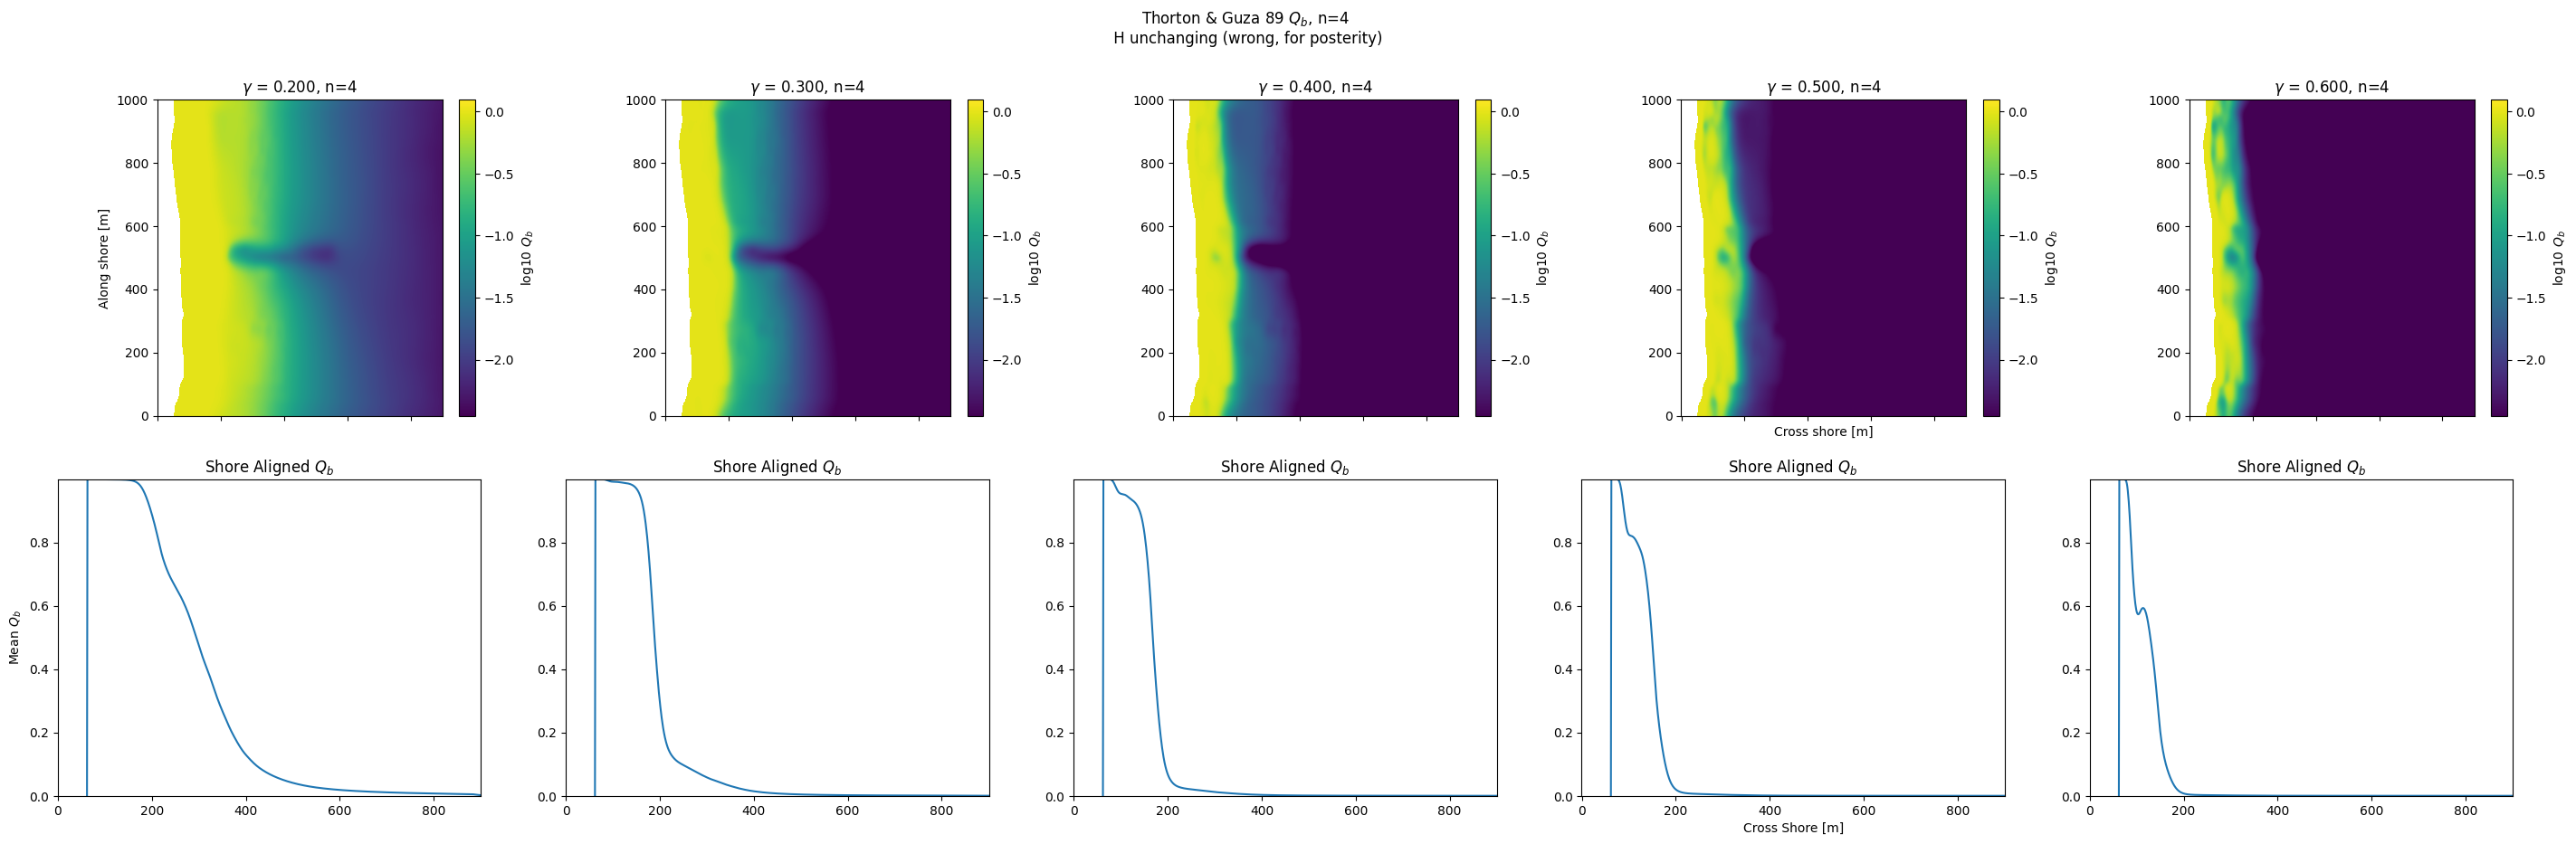

<Figure size 640x480 with 0 Axes>

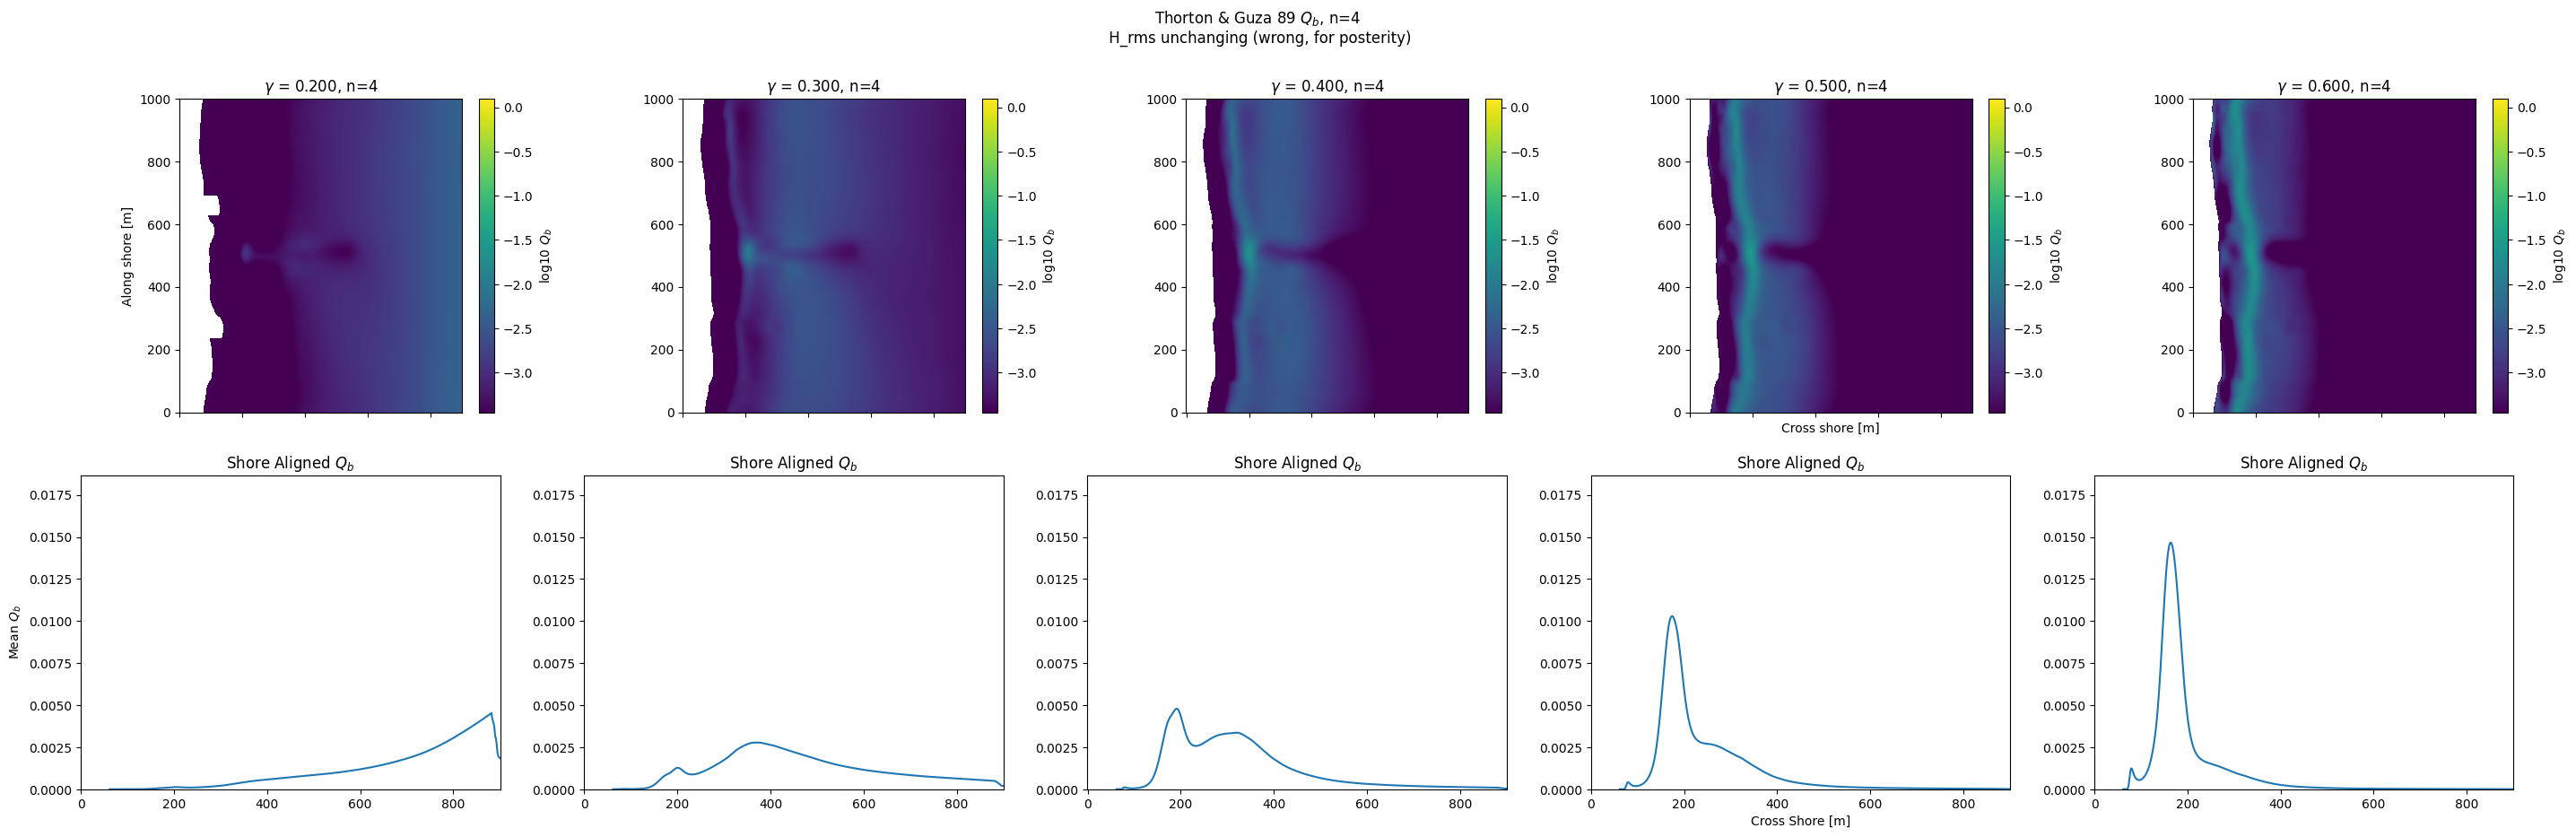

<Figure size 640x480 with 0 Axes>

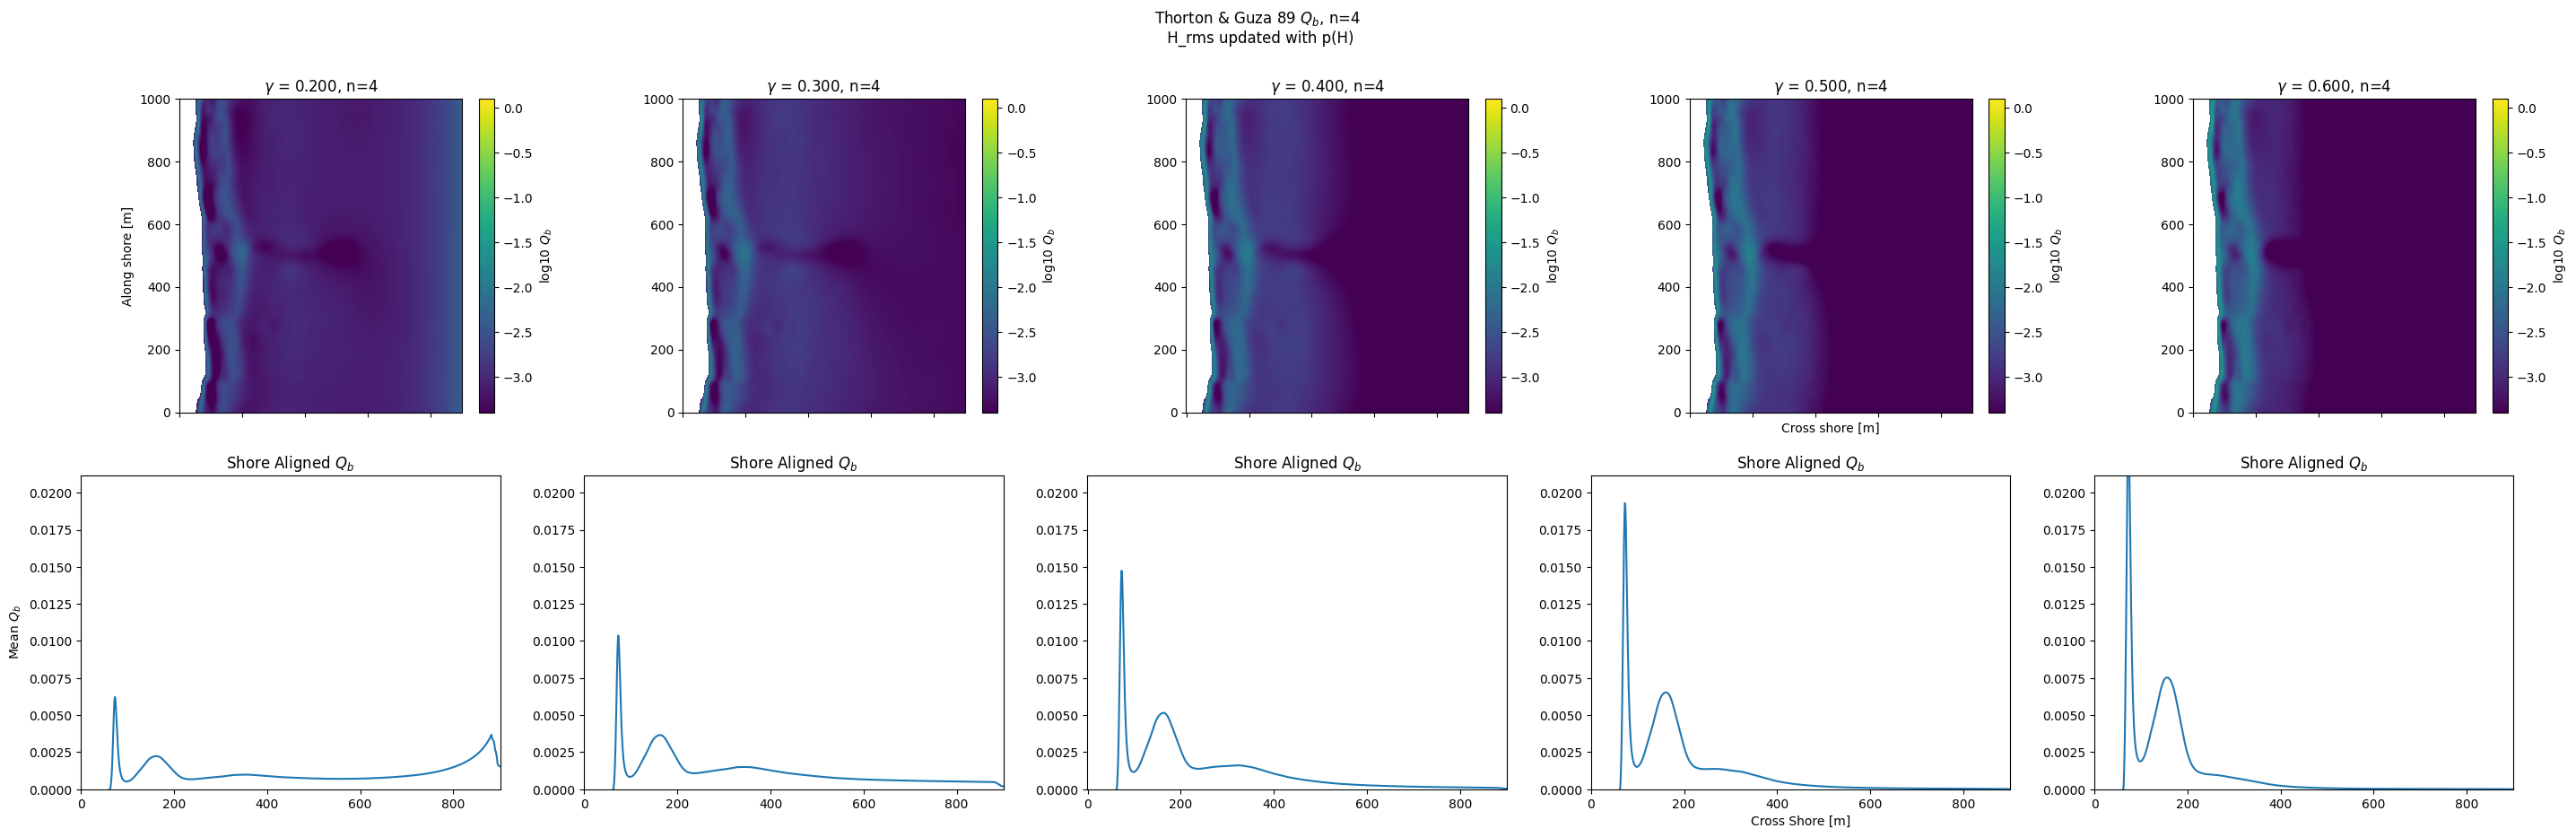

<Figure size 640x480 with 0 Axes>

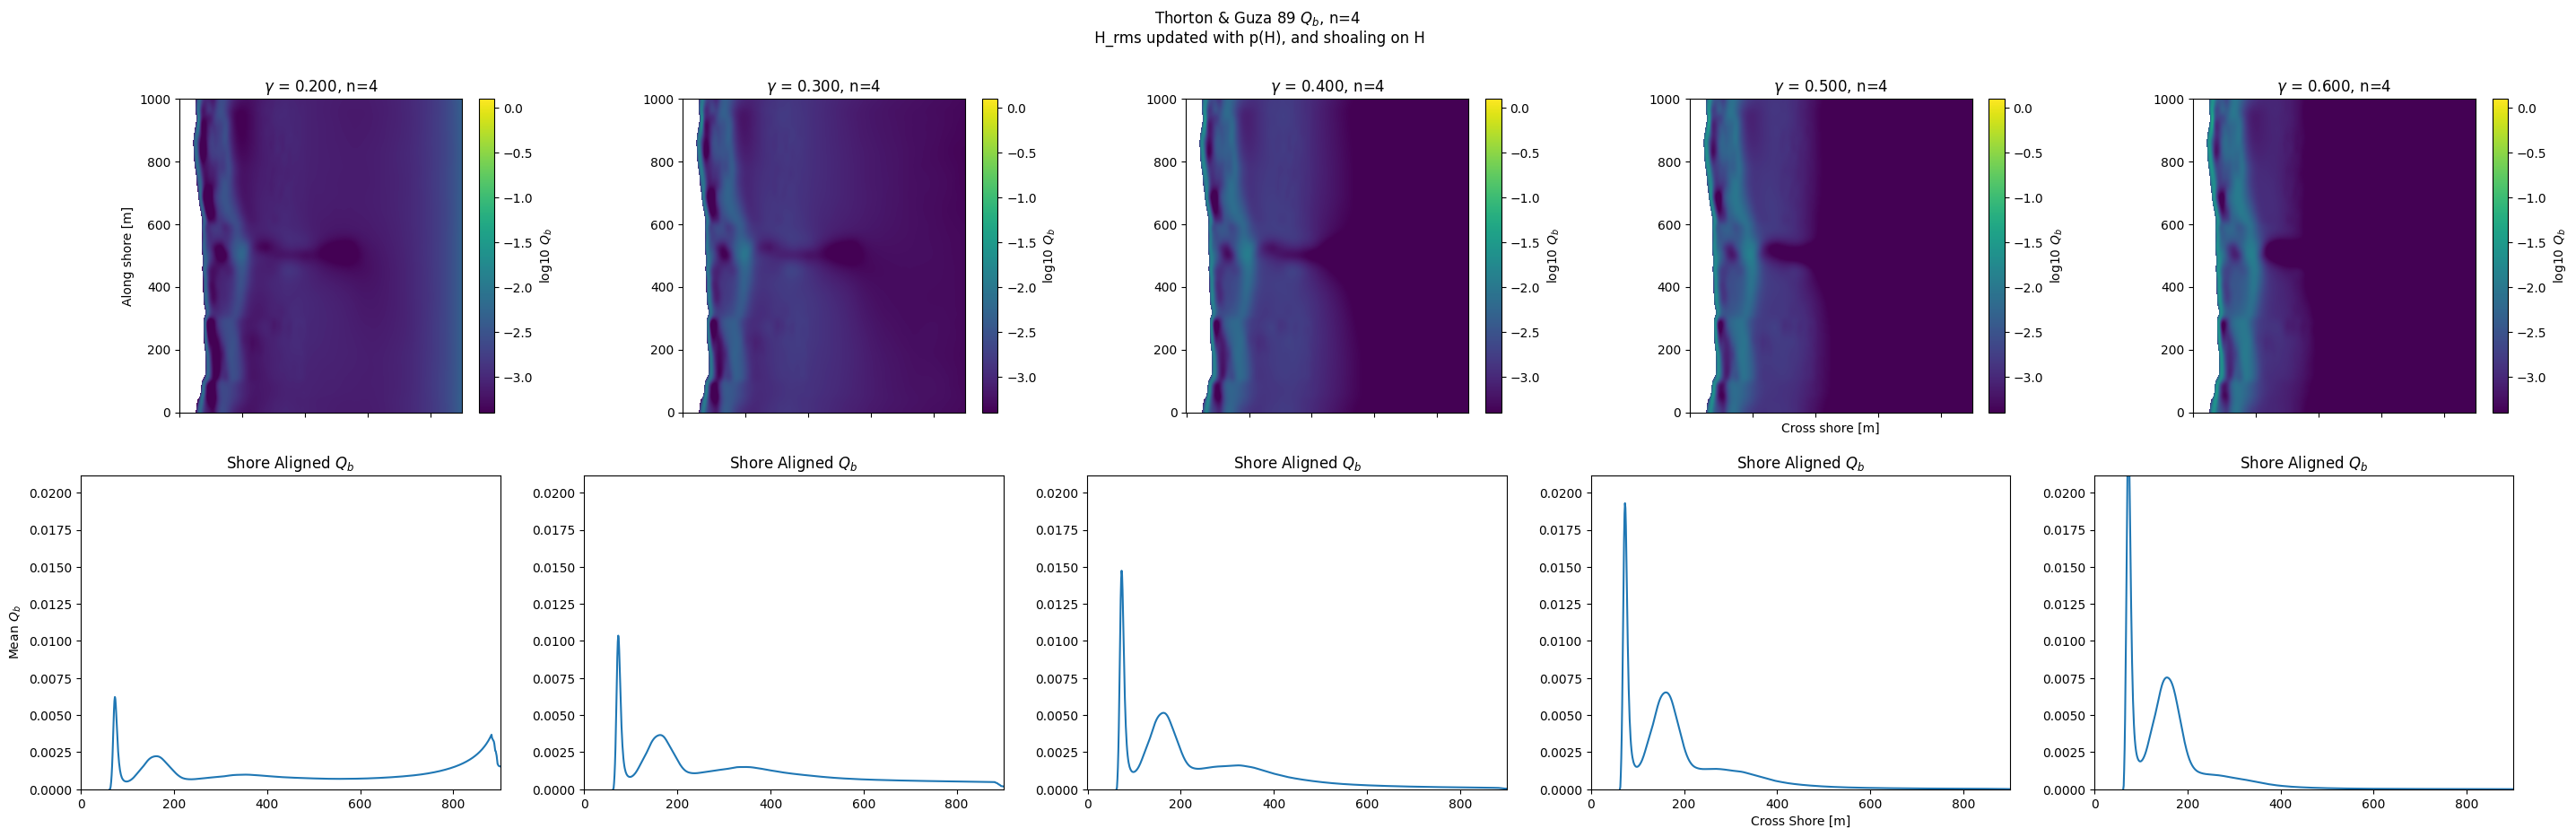

In [1112]:
def plot_qbs(qb):
    qb_max = np.percentile(np.nan_to_num(qb, 0), 60)
    qb_min = np.percentile(np.nan_to_num(qb, 0), 5)
    fig, axs = plt.subplots(2, len(gammas), figsize=(35, 10), sharex=True, sharey=False)
    for g in range(len(gammas)):
        ax = axs[0, g]
        im = ax.imshow(np.log10(qb[g]), vmin=np.log10(qb_min), vmax=np.log10(qb_max))
        ax.set_title(rf'$\gamma$ = {gammas[g]:.3f}, n={n}')
        fig.colorbar(im, ax=ax, fraction=0.051, pad=0.04, label='log10 $Q_b$')
        
        ax = axs[1, g]
        shoreline = np.argmax(
            np.isnan(bathy.h.values) * np.arange(0, 901),
            axis=1)
        aligned_qb = np.zeros_like(qb[g])
        for j, start in enumerate(shoreline):
            aligned_qb[j, 0:aligned_qb.shape[1] - start] = qb[g, j, start:]
        mean_shoreline = int(shoreline.mean(0))
        ax.plot(np.arange(901)[mean_shoreline:], aligned_qb.mean(0)[:-mean_shoreline])
        ax.set_title('Shore Aligned $Q_b$')
        ax.set_ylim(0, np.percentile(np.nan_to_num(qb[-1], 0), 99.5))

    axs[0, 0].set_ylabel('Along shore [m]')
    axs[0, 3].set_xlabel('Cross shore [m]')
    axs[1, 0].set_ylabel('Mean $Q_b$')
    axs[1, 3].set_xlabel('Cross Shore [m]')
    axs[1, 3].set_title('Shore Aligned $Q_b$');
    return fig

plot_qbs(qb_static_H).suptitle(f"Thorton & Guza 89 $Q_b$, {n=}\n H unchanging (wrong, for posterity)")
plt.figure()
plot_qbs(qb_static_hrms).suptitle(f"Thorton & Guza 89 $Q_b$, {n=}\n H_rms unchanging (wrong, for posterity)")
plt.figure()
plot_qbs(qb_changing_hrms).suptitle(f"Thorton & Guza 89 $Q_b$, {n=}\n H_rms updated with p(H)")
plt.figure()
plot_qbs(qb_changing_hrms_and_shoaling).suptitle(f"Thorton & Guza 89 $Q_b$, {n=}\n H_rms updated with p(H), and shoaling on H")

# QB Inversion to Gamma

Now we can explore the inverse problem of starting with a map of gamma (from argus data for example) and trying to calculate the depths based on offshore wave conditions. 

We'll assume we have qb.shape == (nX, nY), and p(H).shape == (nH) as our givens.

To start, we'll simply pick a gamma & n. In the future we may explore optimizing these as well as depth. 


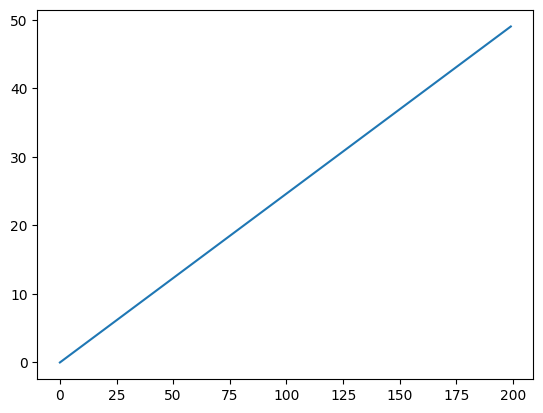

In [1047]:
plt.plot(H)

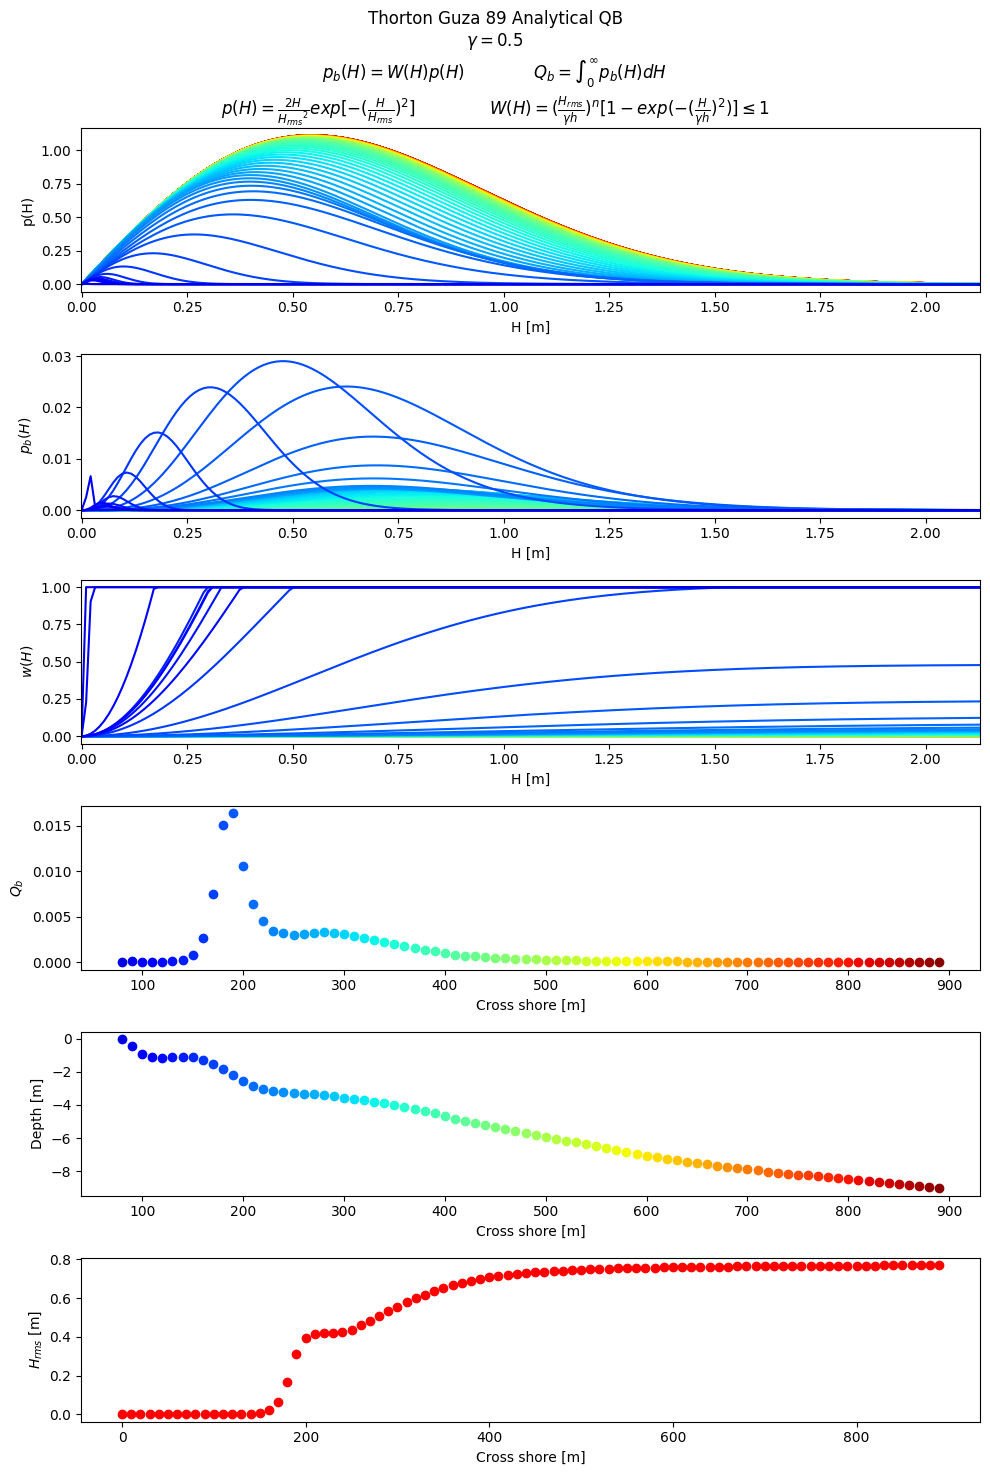

In [1098]:
# I fixed to update H_rms here as H changes.
gamma = 0.5
i = 200
update_hrms = True
shoal_H = True # The effect of shoaling is only clearly visible at high gammas, otherwise the big waves just break and get removed from the distribution off shore
pH = p(H)
hrms=np.nan_to_num(np.sqrt(np.trapz(H**2 * pH, H)), 0)
colors = plt.cm.jet(np.arange(900))    
modified_pHs = np.zeros((nx, nH))
modified_Hs = np.zeros((nx, nH))

fig, axs = plt.subplots(6, 1, figsize=(10,15))
shoaled_H = H.copy()
shoal_H = True
shoaling_coefficient[250:] = 1

for j in reversed(range(900)):
    h = bathy.h.values[i, j]
    if shoal_H:
        # This shifts pH onto the shoaled heights of the waves.
        pH = np.interp(H, H * shoaling_coefficient[j], pH)
    
    if update_Hrms:
        hrms=np.nan_to_num(np.sqrt(np.trapz(H**2 * pH, H)), 1e-9)
    
    wH = w(H, H_rms=hrms, h=h, gamma=gamma, n=4)
    pb = pH * wH
    pH -= pb
        
    modified_pHs[j] = pH
    # modified_Hs[j] = shoaled_H
    if j%10 == 0:
        axs[0].plot(H, pH, color=plt.cm.jet(j/900))
        axs[1].plot(H, pb, color=plt.cm.jet(j/900))
        axs[2].plot(H, wH, color=plt.cm.jet(j/900))
        axs[3].scatter(j, np.sum(pb) * dH, color=[plt.cm.jet(j/900)])
        axs[4].scatter(j, h, c=[plt.cm.jet(j/900)])
        axs[5].scatter(j, np.nan_to_num(np.sqrt(np.trapz(H**2 * pH, H)), 0), c='r')

axs[0].set_xlabel('H [m]')
axs[0].set_ylabel('p(H)')
for i in range(3):
    axs[i].set_xlim(-0.001, H.max())
axs[1].set_xlabel('H [m]')
axs[1].set_ylabel('$p_b(H)$')

axs[2].set_xlabel('H [m]')
axs[2].set_ylabel('$w(H)$')

axs[3].set_xlabel('Cross shore [m]')
axs[3].set_ylabel('$Q_b$')

axs[4].set_xlabel('Cross shore [m]')
axs[4].set_ylabel('Depth [m]')    

axs[5].set_xlabel('Cross shore [m]')
axs[5].set_ylabel('$H_{rms}$ [m]')    
fig.suptitle(
('Thorton Guza 89 Analytical QB\n'
rf'$\gamma = {gamma}$'
'\n'
r'$p_b(H) = W(H)p(H)$'
'\t\t'
r'$Q_b = \int_0^{\infty} p_b(H) dH$'
'\n'
r'$p(H) = \frac{2H}{{H_{rms}}^2}exp[-(\frac{H}{H_{rms}})^2]$'
'\t\t'
r'$W(H) = (\frac{H_{rms}}{\gamma h})^n[1-exp(-(\frac{H}{\gamma h})^2)] \leq 1$'))
plt.tight_layout()


Text(0.5, 1.0, 'I guess this is the integral change in p(H) per step? or something like Qb?')

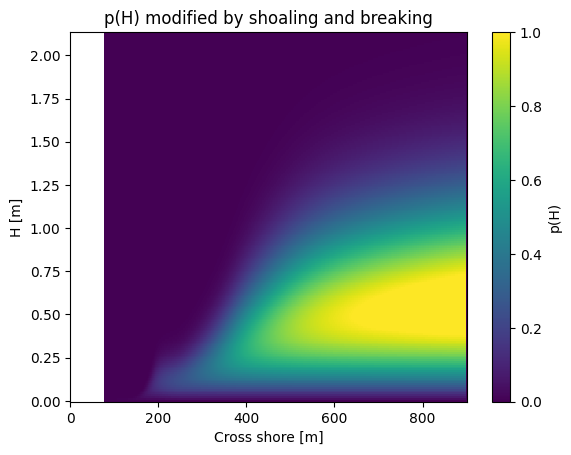

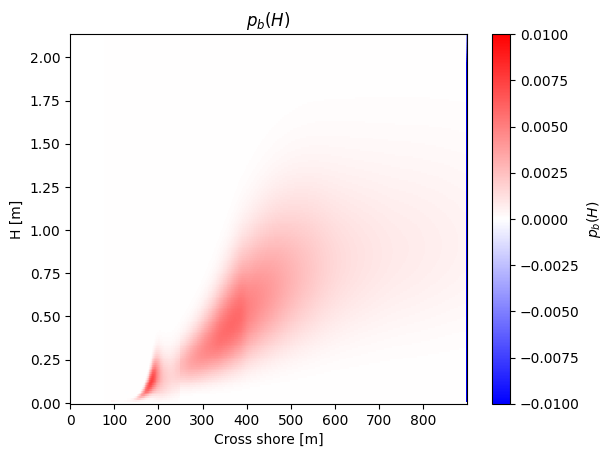

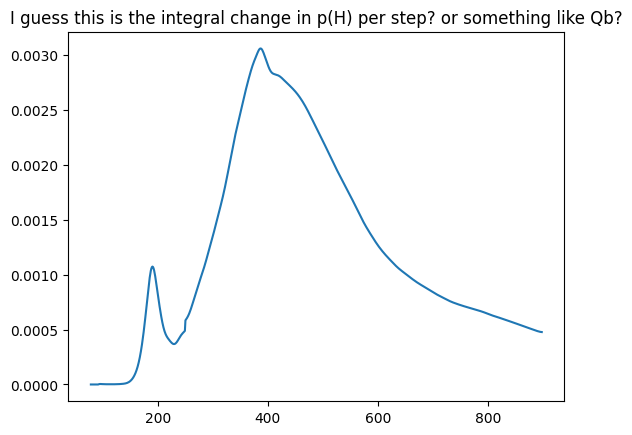

In [1067]:
plt.pcolormesh(np.arange(901), H, modified_pHs.T, vmin=0, vmax=1)
plt.colorbar(label='p(H)')
plt.title('p(H) modified by shoaling and breaking')
plt.xlabel('Cross shore [m]')
plt.ylabel('H [m]')

plt.figure()
plt.pcolormesh(np.arange(900), H, modified_pHs[1:].T - modified_pHs[:-1].T, vmin=-0.01, vmax=0.01, cmap='bwr')
plt.colorbar(label='$p_b(H)$')
plt.title('$p_b(H)$')
plt.xlabel('Cross shore [m]')
plt.ylabel('H [m]')


plt.figure()
plt.plot((modified_pHs[1:].T - modified_pHs[:-1].T).sum(0)[:-1]*dH)
plt.title('I guess this is the integral change in p(H) per step? or something like Qb?')


/var/folders/xv/4vxt441n3tz_yllzvqvzmsgw0000gr/T/ipykernel_95186/4194234531.py:22: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  guess_h_from_linear[j] = fsolve(optimize_hs, h, args=j);
/var/folders/xv/4vxt441n3tz_yllzvqvzmsgw0000gr/T/ipykernel_95186/4194234531.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  guess_h_from_linear[j] = fsolve(optimize_hs, h, args=j);
/var/folders/xv/4vxt441n3tz_yllzvqvzmsgw0000gr/T/ipykernel_95186/4194234531.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  guess_h_minimize[j] = minimize(optimize_hs, h, args=j).x
/var/fold

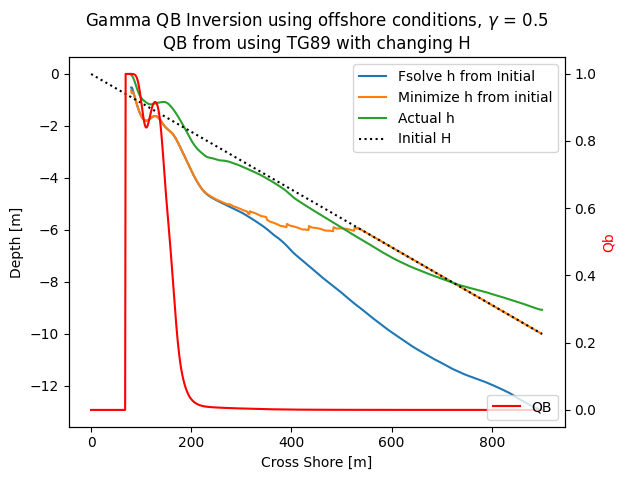

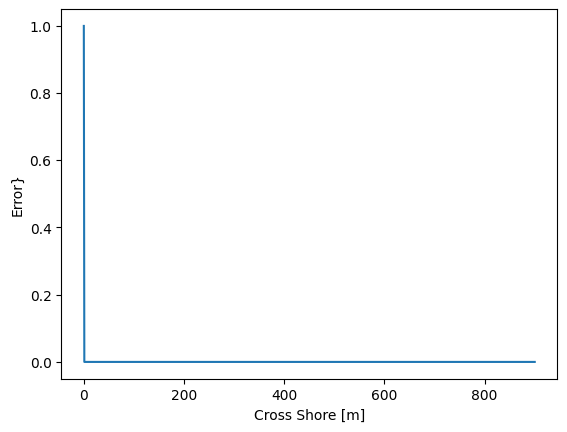

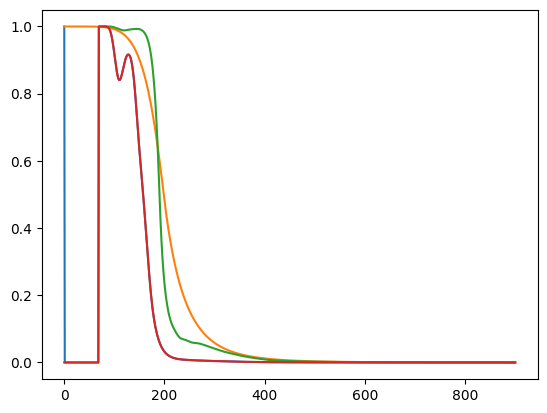

In [1187]:
from scipy.optimize import fsolve, minimize

# gamma = 0.85
g = 3
test_qb = qb_static_H[g, 100, :]
gamma = gammas[g]
i = 200

def calculate_qb_point(h):
    return np.minimum(np.sum(p(H) * w(H, H_rms_offshore, h)) * dH, 1)

def calculate_qb_transect(h):
    return np.minimum(np.sum(p(H_grid) * w(H_grid, H_rms_offshore, h), axis=0) * dH, 1)

def optimize_hs(h, i):
    return (test_qb[i] - calculate_qb_point(h))**2

guess_h_from_linear = np.zeros(901)
guess_h_minimize = np.zeros(901)
initial_h = np.linspace(-0.01, -10, 901)
for j, h in enumerate(initial_h):
    guess_h_from_linear[j] = fsolve(optimize_hs, h, args=j);
    guess_h_minimize[j] = minimize(optimize_hs, h, args=j).x
    # if ier != 1:
    #     print(ier, mesg)

clip = 80
plt.plot(np.arange(901)[clip:-1], guess_h_from_linear[clip:-1], label='Fsolve h from Initial')
plt.plot(np.arange(901)[clip:-1], guess_h_minimize[clip:-1], label='Minimize h from initial')
plt.plot(np.arange(nx), bathy.h.values[i], label='Actual h')
plt.plot(np.arange(nx), initial_h, c='k', linestyle=':', label='Initial H')
plt.legend()
plt.ylabel('Depth [m]')
plt.xlabel('Cross Shore [m]')
plt.twinx().plot(test_qb, c='r', label='QB')
plt.ylabel('Qb', c='r')
plt.legend(loc=4)
plt.title(fr'Gamma QB Inversion using offshore conditions, $\gamma$ = {gamma}'+'\nQB from using TG89 with changing H')

plt.figure()
plt.plot([optimize_hs(h, i) for i, h in enumerate(guess_h)])
plt.ylabel('Error}')
plt.xlabel('Cross Shore [m]')

plt.figure()
plt.plot(np.arange(nx), calculate_qb_transect(guess_h))
plt.plot(np.arange(nx), calculate_qb_transect(np.linspace(0, -10, nx)))
plt.plot(np.arange(nx), calculate_qb_transect(bathy.h.values[i]))
plt.plot(np.arange(nx), test_qb);

In [1190]:
from scipy.optimize import fsolve, minimize

# gamma = 0.85
g = 3
test_qb = qb_static_H[g, 100, :]
gamma = gammas[g]
i = 200

def calculate_qb_point(h):
    return np.minimum(np.sum(p(H) * w(H, H_rms_offshore, h)) * dH, 1)

def calculate_qb_transect(h):
    return np.minimum(np.sum(p(H_grid) * w(H_grid, H_rms_offshore, h), axis=0) * dH, 1)

def optimize_hs_transect(h):
    return (test_qb - calculate_qb_transect(h))**2

guess_h_from_linear = np.zeros(901)
guess_h_minimize = np.zeros(901)
initial_h = np.linspace(-0.01, -10, 901)
guess_h_minimize[j] = minimize(optimize_hs_transect, initial_h).x
# for j, h in enumerate(initial_h):
#     # guess_h_from_linear[j] = fsolve(optimize_hs, h, args=j);
#     guess_h_minimize[j] = minimize(optimize_hs_transect, initial_h).x
    # if ier != 1:
    #     print(ier, mesg)

clip = 80
plt.plot(np.arange(901)[clip:-1], guess_h_from_linear[clip:-1], label='Fsolve h from Initial')
plt.plot(np.arange(901)[clip:-1], guess_h_minimize[clip:-1], label='Minimize h from initial')
plt.plot(np.arange(nx), bathy.h.values[i], label='Actual h')
plt.plot(np.arange(nx), initial_h, c='k', linestyle=':', label='Initial H')
plt.legend()
plt.ylabel('Depth [m]')
plt.xlabel('Cross Shore [m]')
plt.twinx().plot(test_qb, c='r', label='QB')
plt.ylabel('Qb', c='r')
plt.legend(loc=4)
plt.title(fr'Gamma QB Inversion using offshore conditions, $\gamma$ = {gamma}'+'\nQB from using TG89 with changing H')

plt.figure()
plt.plot([optimize_hs(h, i) for i, h in enumerate(guess_h)])
plt.ylabel('Error}')
plt.xlabel('Cross Shore [m]')

plt.figure()
plt.plot(np.arange(nx), calculate_qb_transect(guess_h))
plt.plot(np.arange(nx), calculate_qb_transect(np.linspace(0, -10, nx)))
plt.plot(np.arange(nx), calculate_qb_transect(bathy.h.values[i]))
plt.plot(np.arange(nx), test_qb);

KeyboardInterrupt: 